In [12]:
import json
import sys
import os
import time
import neuron
from pathlib import Path

import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import model
import evaluator

%matplotlib notebook

In [13]:
probe_type = "linear"
model_name = 'hay' # "hay"

In [14]:
model_folder = (Path(".") / f"{model_name}_model").absolute()

# compile model-specific mechanisms
if not (model_folder / "x86_64").is_dir():
    curr_dir = Path(".")
    os.chdir(model_folder)
    print(os.getcwd())
    os.system("nrnivmodl mechanisms")
    os.chdir(curr_dir)
else:
    print(f"Mechanisms already compiled for {model_name}")

Mechanisms already compiled for hay


In [8]:
neuron.load_mechanisms(str(model_folder))

Mechanisms already loaded from path: /Users/abuccino/Documents/Codes/modeling/multimodal-fitting/multimodalfitting/models/hay_model.  Aborting.


True

In [21]:
cell = model.create(model_name=model_name, release=True)

probe = model.define_electrode(probe_type=probe_type)

param_names = [param.name for param in cell.params.values() if not param.frozen]

fitness_protocols = evaluator.define_protocols(
    model_name,
    feature_set="multiple",
    feature_file=f"{model_name}_model/features_list.json",
    electrode=probe,
    protocols_with_lfp=["Step1"]
)

fitness_calculator = ephys.objectivescalculators.ObjectivesCalculator([])

if model_name == 'hallermann':
    sim = ephys.simulators.LFPySimulator(cell, cvode_active=False, electrode=probe)
else:
    sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe)

eva = ephys.evaluators.CellEvaluator(                    
        cell_model=cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)

In [22]:
fitness_protocols

{'bAP': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fc22c560970>,
 'BAC': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fc22c55fbb0>,
 'EPSP': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fc22c55fe50>,
 'CaBurst': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fc22c5670d0>,
 'Step1': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fc22c5673a0>}

In [ ]:
t_start = time.time()
responses = eva.run_protocols(protocols=fitness_protocols.values(), param_values={})
print(f"Elapsed time: {time.time() - t_start}")

<IPython.core.display.Javascript object>


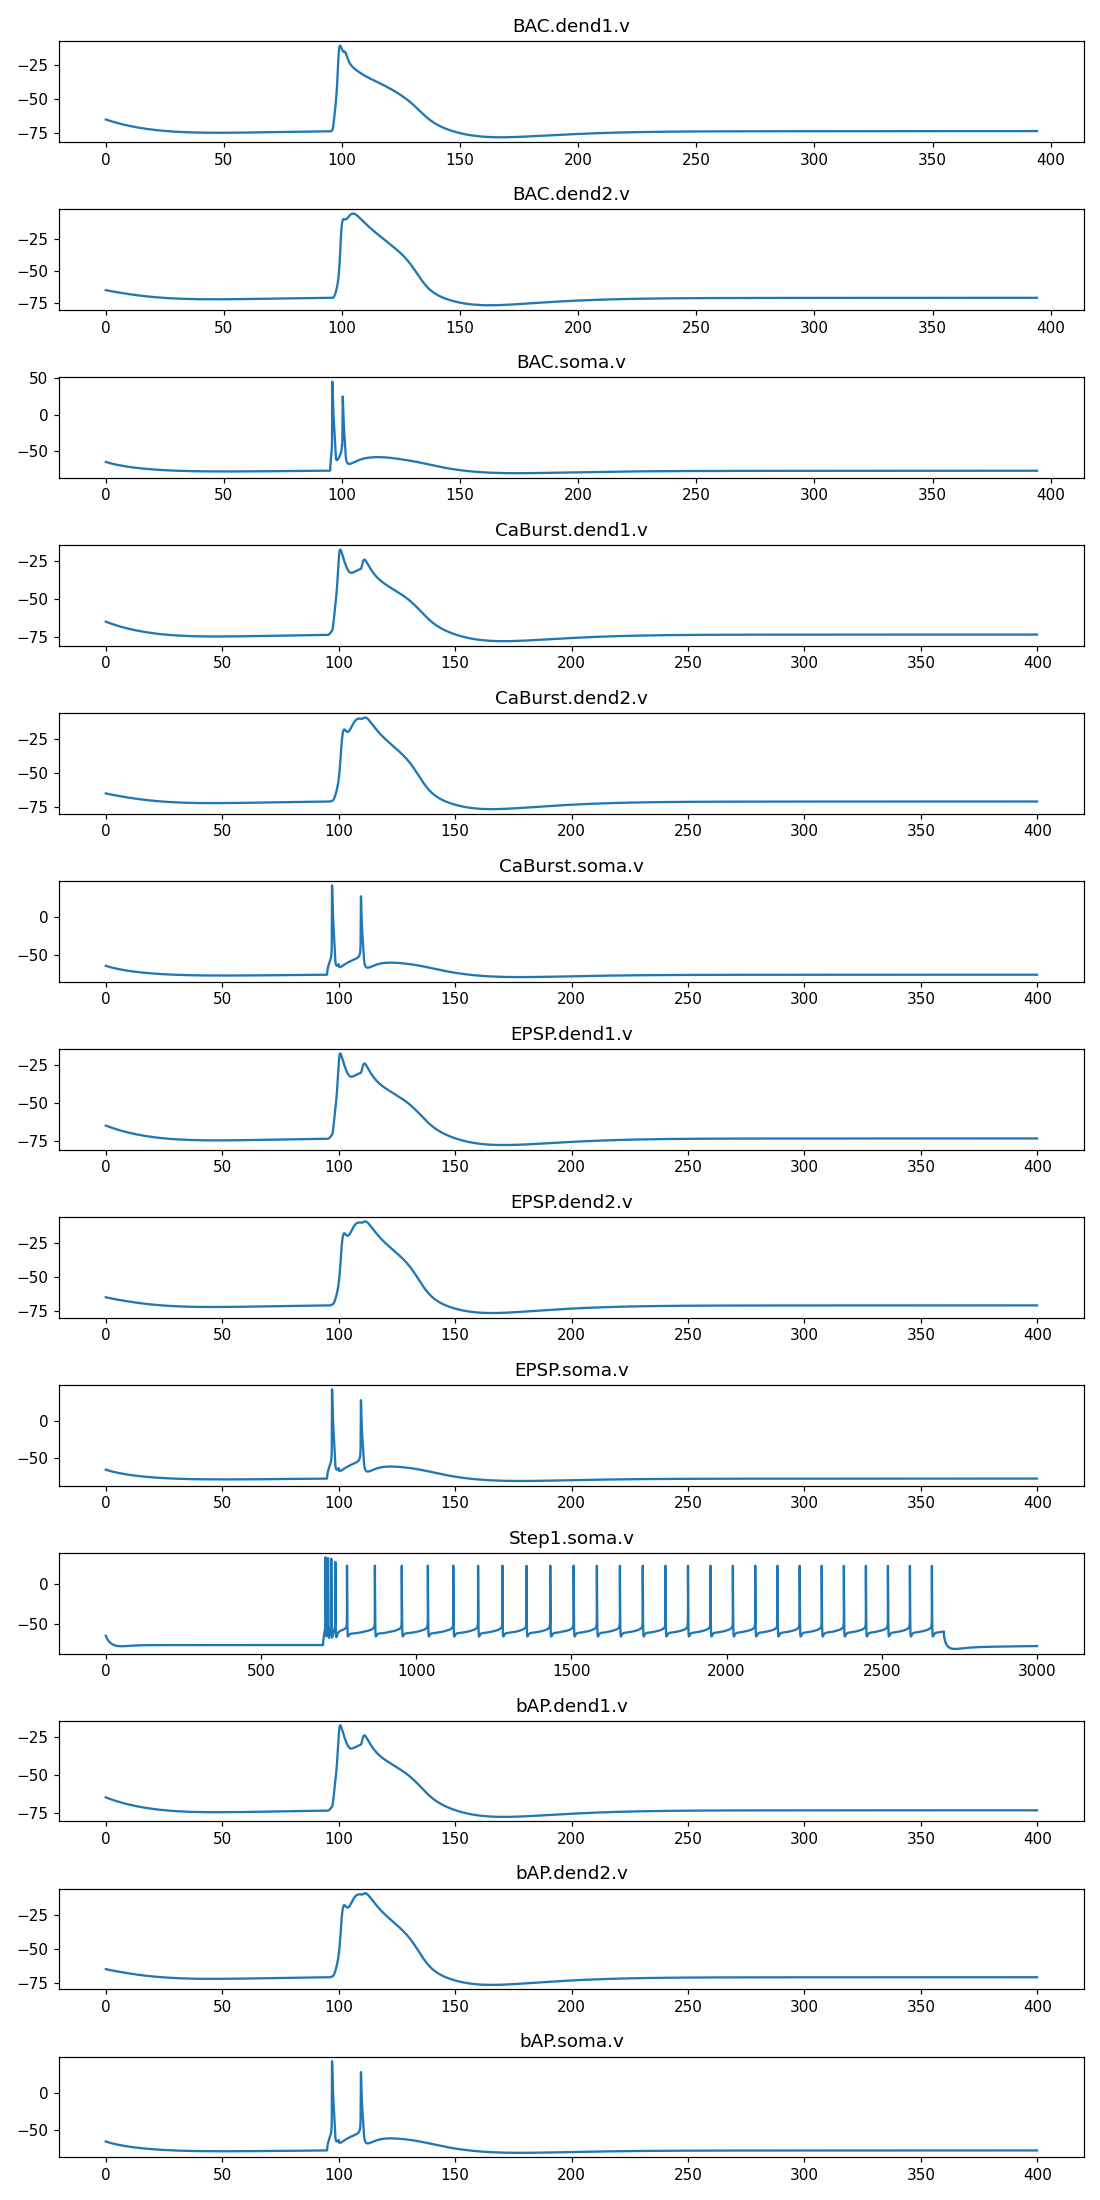

In [19]:
fig, axes = plt.subplots(len(responses), figsize=(10, 20), squeeze=False)
for index, (resp_name, response) in enumerate(sorted(responses.items())):
    axes[index, 0].plot(response['time'], response['voltage'], label=resp_name)
    axes[index, 0].set_title(resp_name)
fig.tight_layout()
fig.show()

In [20]:
responses.keys() #["Step1"]

dict_keys(['bAP.soma.v', 'bAP.dend1.v', 'bAP.dend2.v', 'BAC.soma.v', 'BAC.dend1.v', 'BAC.dend2.v', 'EPSP.soma.v', 'EPSP.dend1.v', 'EPSP.dend2.v', 'CaBurst.soma.v', 'CaBurst.dend1.v', 'CaBurst.dend2.v', 'Step1.soma.v'])

In [ ]:
plt.figure()
plt.plot(responses['Step1.MEA.LFP']["time"], responses['Step1.MEA.LFP']["voltage"].T)

In [ ]:
responses['Step1.MEA.LFP']["voltage"]

In [ ]:
responses['Step1.MEA.LFP']["voltage"]